In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import os

In [3]:
def read_data(path, filename, delete_nans=False, verbose = False):
    df = pd.read_csv(f'{path}/{filename}')
    print(f"columns: {df.columns}")
    if verbose: print(f"all data length = {len(df)}")
    for col in df.columns:
        nan_count = df[col].isna().sum()
        if nan_count==len(df):
            df = df.drop(columns=col) 
            if verbose: print(f"column {col} was deleted")
    if verbose: print(f"number of column = {len(df.columns)}")
    if delete_nans:
        cols_to_check = [col for col in df.columns if col not in ['date']]
        rows_to_delete = df[cols_to_check].isna().all(axis=1).sum()
        if verbose: print(f"Будет удалено строк: {rows_to_delete}")
        df = df.dropna(subset=cols_to_check, how='all')
    print(f"final data length = {len(df)}")
    return df



all data length = 20301
column packet_id was deleted (all NaNs)
column latitude was deleted (all NaNs)
column longitude was deleted (all NaNs)
column T station was deleted (all NaNs)
column RH was deleted (all NaNs)
column p was deleted (all NaNs)
column PM2 was deleted (all NaNs)
column PM10 was deleted (all NaNs)
column CO was deleted (all NaNs)
column NO2 was deleted (all NaNs)
column O3 was deleted (all NaNs)
column NO2op1 was deleted (all NaNs)
column NO2op2 was deleted (all NaNs)
column NO2t was deleted (all NaNs)
column O3op1 was deleted (all NaNs)
column O3op2 was deleted (all NaNs)
column O3t was deleted (all NaNs)
column COop1 was deleted (all NaNs)
column COop2 was deleted (all NaNs)
column COt was deleted (all NaNs)
column g1_mt was deleted (all NaNs)
column g1_mh was deleted (all NaNs)
column g3_data was deleted (all NaNs)
Будет удалено строк: 536
final data length = 19765
SO2: 19310 baseline (после фильтрации)
H2S: 19553 baseline (после фильтрации)

[Типизация переменных]

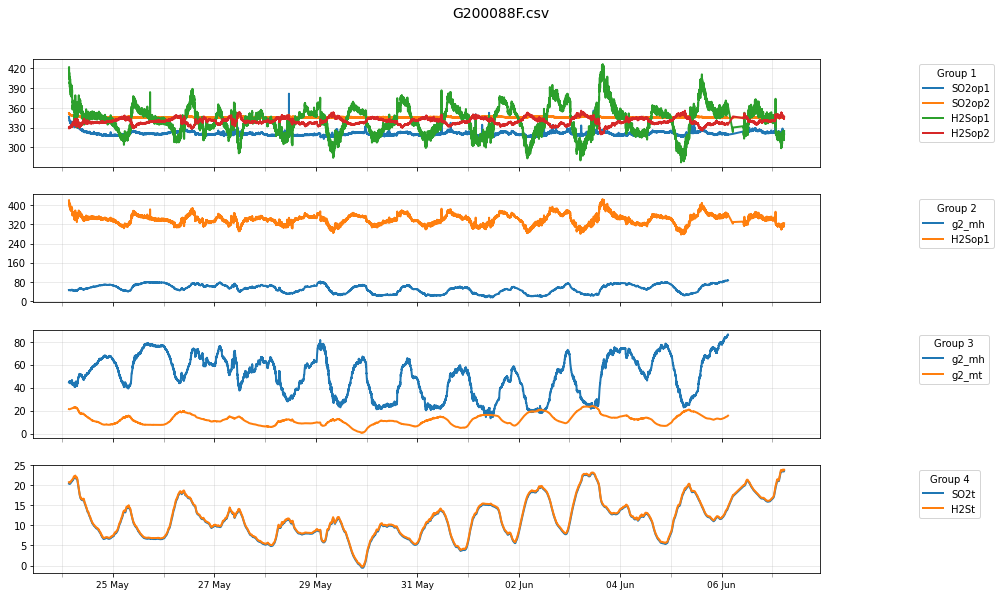

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import pandas as pd

def compute_baseline_mask(
    df,
    gas,
    signal_col=None,
    baseline_eps=0.01,
    use_iqr=True,
    use_isolation=False,
    contamination=None,
    verbose=False
):
    """
    Универсальная функция для расчёта baseline-маски (bl) для одного газа.
    df            — DataFrame с данными
    gas           — имя газа ('NO2', 'SO2', ...)
    signal_col    — имя сигнальной колонки (по умолчанию f'{gas}op1')
    baseline_eps  — допустимый уровень "нуля" для концентрации газа
    use_iqr       — использовать ли IQR-фильтрацию по сигналу
    use_isolation — использовать ли IsolationForest для мультифакторной фильтрации
    contamination — доля выбросов для IsolationForest (если None — автооценка по IQR)
    verbose       — печатать ли статистику
    """
    from sklearn.ensemble import IsolationForest

    if signal_col is None:
        signal_col = f"{gas}op1"
    temp_col = f"{gas}t"

    # 1. Простейший baseline по концентрации газа
    valid_mask = df[signal_col].notna()
    bl_mask = (df[gas].fillna(0) < baseline_eps) & valid_mask

    if use_iqr:
        q1 = df.loc[bl_mask, signal_col].quantile(0.25)
        q3 = df.loc[bl_mask, signal_col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        iqr_mask = df[signal_col].between(lower, upper)
        bl_mask = bl_mask & iqr_mask

    if use_isolation:
        features = [signal_col]
        if temp_col in df: features.append(temp_col)
        if 'MH' in df: features.append('MH')
        if f"{temp_col}_grad" in df: features.append(f"{temp_col}_grad")
        if 'MH_grad' in df: features.append('MH_grad')
        iso_df = df.loc[bl_mask, features].dropna()
        if not iso_df.empty:
            # Оцениваем contamination по IQR, если не задано явно
            if contamination is None and use_iqr:
                extreme = (df.loc[bl_mask, signal_col] < lower) | (df.loc[bl_mask, signal_col] > upper)
                contamination_est = min(max(extreme.sum() / len(extreme), 0.001), 0.2)
            else:
                contamination_est = contamination if contamination is not None else 0.02
            if verbose:
                print(f"{gas}: estimated contamination = {contamination_est:.4f}")
            iso = IsolationForest(contamination=contamination_est, random_state=42)
            outliers = iso.fit_predict(iso_df)
            bad_idx = iso_df.index[outliers == -1]
            bl_mask.loc[bad_idx] = False

    if verbose:
        print(f"{gas}: {bl_mask.sum()} baseline (после фильтрации)")

    return bl_mask




def plot_data(df, filename,
              plot_blocks=None,
              start_date=None,
              end_date=None):
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.ticker import MaxNLocator

    def plot_column(ax, df, col, linewidth=2.0):
        if col not in df.columns or df[col].dropna().empty:
            return
        is_bool_col = df[col].dropna().isin([0, 1, True, False]).all()
        if is_bool_col:
            x = df['date']
            y1 = np.zeros(len(df))
            y2 = np.full(len(df), 0.8)
            mask = df[col].astype(bool).fillna(False).values
            if len(x) == len(mask):
                ax.fill_between(x, y1, y2, where=mask,
                                color='orange', alpha=0.3, transform=ax.get_xaxis_transform(), label=col)
        else:
            ax.plot(df['date'], pd.to_numeric(df[col], errors='coerce'), label=col, linewidth=linewidth)



    df['date'] = pd.to_datetime(df['date'])
    tz = df['date'].dt.tz
    if start_date:
        sd = pd.to_datetime(start_date)
        if tz is not None:
            if sd.tzinfo is None:
                sd = sd.tz_localize(tz)
            else:
                sd = sd.tz_convert(tz)
        df = df[df['date'] >= sd]
    if end_date:
        ed = pd.to_datetime(end_date)
        if tz is not None:
            if ed.tzinfo is None:
                ed = ed.tz_localize(tz)
            else:
                ed = ed.tz_convert(tz)
        df = df[df['date'] <= ed]

    if plot_blocks is None:
        plot_blocks = [[], [], [], []]
    elif len(plot_blocks) < 4:
        plot_blocks += [[]] * (4 - len(plot_blocks))
    plot_blocks = [[col for col in group if col in df.columns] for group in plot_blocks]

    fig, axes = plt.subplots(4, 1, figsize=(14, 8), sharex=True)
    for i, ax in enumerate(axes):
        for col in plot_blocks[i]:
            plot_column(ax, df, col)
        if plot_blocks[i]:
            ax.legend(loc='upper left', bbox_to_anchor=(1.12, 1), title=f'Group {i+1}')

    time_span = df['date'].max() - df['date'].min()
    days = time_span.days
    hours = time_span.total_seconds() / 3600

    if days > 30:
        major_locator = mdates.MonthLocator()
        minor_locator = mdates.WeekdayLocator(interval=1)
        major_formatter = mdates.DateFormatter('%d %b\n%Y')
    elif days >= 2:
        major_locator = mdates.DayLocator(interval=max(1, days // 7))
        minor_locator = mdates.DayLocator()
        major_formatter = mdates.DateFormatter('%d %b')
    elif hours >= 6:
        major_locator = mdates.HourLocator(interval=max(1, int(hours / 6)))
        minor_locator = mdates.HourLocator(interval=1)
        major_formatter = mdates.DateFormatter('%H:%M\n%d %b')
    else:
        major_locator = mdates.MinuteLocator(byminute=range(0, 60, 15))
        minor_locator = mdates.MinuteLocator(byminute=range(0, 60, 5))
        major_formatter = mdates.DateFormatter('%H:%M')

    for ax in axes:
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_formatter)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.tick_params(axis='x', which='major', labelsize=9)
        ax.tick_params(axis='x', which='minor', length=4, color='gray')
        ax.yaxis.set_major_locator(MaxNLocator(6))
        ax.grid(True, which='both', axis='x', alpha=0.3)
        ax.grid(True, axis='y', alpha=0.3)

    fig.suptitle(filename, y=1.03, fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)
    plt.show()


def read_data(path, filename, delete_nans=False, verbose=True, gases=None, std_thr=0.1, window=5):
    if gases is None:
        gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']

    df = pd.read_csv(f'{path}/{filename}')
    # display(df)
    if verbose:
        print(f"all data length = {len(df)}")
    if 'ts' in df.columns:
        df = df.drop(columns=['ts'])

    # Удаление полностью пустых колонок
    for col in df.columns:
        if df[col].isna().sum() == len(df):
            df = df.drop(columns=col)
            if verbose:
                print(f"column {col} was deleted (all NaNs)")

    # Удаление полностью пустых строк (кроме 'date')
    if delete_nans:
        cols_to_check = [col for col in df.columns if col != 'date']
        rows_to_delete = df[cols_to_check].isna().all(axis=1).sum()
        if verbose:
            print(f"Будет удалено строк: {rows_to_delete}")
        df = df.dropna(subset=cols_to_check, how='all')

    if verbose:
        print(f"final data length = {len(df)}")



    for gas in gases:
        if gas in df.columns and f"{gas}op1" in df.columns:
            df[f"{gas}op1_bl"] = compute_baseline_mask(
                            df, gas,
                            baseline_eps=0.01,
                            use_iqr=True,           # или False, если хочешь "сырой" baseline
                            use_isolation=False,    # True — если нужна очистка
                            verbose=True
                        )
            signal = df[f"{gas}op1"]            
            stat_mask = signal.rolling(window, center=True).std() < std_thr
            df[f"{gas}op1_stat"] = stat_mask.fillna(False) & (~df[f"{gas}op1_bl"])
        else:
            df[f"{gas}op1_bl"] = False
            df[f"{gas}op1_stat"] = False

    types = {
        'bool': [],
        'small': [],
        'middle': [],
        'large': []
    }
    numeric_cols = [col for col in df.columns if col != 'date' and pd.api.types.is_numeric_dtype(df[col])]
    for col in numeric_cols:
        values = df[col].dropna()
        if values.empty:
            continue
        unique_vals = set(values.unique())
        mean_val = values.mean()
        std_val = values.std()
        if unique_vals <= {0, 1}:
            types['bool'].append(col)
        elif mean_val > 100 or std_val > 50:
            types['large'].append(col)
        elif std_val > 10:
            types['middle'].append(col)
        else:
            types['small'].append(col)
    if verbose:
        print("\n[Типизация переменных]")
        for key, val in types.items():
            print(f"{key.upper():>6}: {val}")

    return df, types

path  = "data_example/lab_data"
path  = "data_example/field_data"
filename = 'G200088F.csv'
start_date="2024-12-4"
end_date="2024-12-31"

df, types = read_data(path, filename, delete_nans=True, std_thr=0.5, window=5)
start_date = df['date'].min()
end_date = df['date'].max()

# gas = 'SO2'
# cols_1 = [f'{gas}op1_stat_auto', f'{gas}op1', f'{gas}op2', 'O3']
# cols_1 = [f'{gas}op1', f'{gas}op2']
# cols_2 = [gas]
# cols_3 = ['g1_mh', 'NO2op1_stat']
# cols_4 = [f'{gas}t', 'stat']
cols_1 = []
cols_2 = []
cols_3 = []
cols_4 = []

gases = ['NO2', 'CO', 'O3', 'SO2', 'H2S']
for gas in gases:
    if f'{gas}op1' in df.columns:
        cols_1.append(f'{gas}op1')
    if f'{gas}op2' in df.columns:
        cols_1.append(f'{gas}op2')
    if gas in df.columns:
        cols_2.append(gas)
    if f'{gas}t' in df.columns:
        cols_4.append(f'{gas}t')
if 'g2_mh' in df.columns:
    cols_3.append('g2_mh')
if 'g2_mt' in df.columns:
    cols_3.append('g2_mt')
if 'stat' in df.columns:
    cols_4.append('stat')

cols_2 = ['g2_mh','H2Sop1']
plot_data(
    df,
    filename=filename,
    plot_blocks=[cols_1,cols_2,cols_3,cols_4],  # остальные группы можно оставить пустыми
    start_date=start_date,
    end_date=end_date
)



In [44]:
print(df[['NO2op1', 'NO2op2', 'NO2','ts']].describe())


             NO2op1        NO2op2      NO2            ts
count  19770.000000  19770.000000  19770.0  1.977000e+04
mean     231.737556    240.475274      0.0  1.717117e+12
std        2.858780      1.951370      0.0  3.463726e+08
min        0.000000      0.000000      0.0  1.716520e+12
25%      230.181250    239.975000      0.0  1.716818e+12
50%      231.911000    240.594500      0.0  1.717116e+12
75%      233.450750    241.113000      0.0  1.717412e+12
max      240.616000    243.053000      0.0  1.717738e+12
